In [ ]:
import cv2 as cv 
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading Dataset

In [ ]:
datasetPath = '/content/drive/MyDrive/Assignment2_BikeHorses'


def createDataset():
   
    images = []
    labels = []
    label = -1

    subFolders = ['Bikes', 'Horses']
    
    for directory in subFolders:
        label = label + 1
        filepath = datasetPath + '/' + directory
        files = []
        for file in os.listdir(filepath):
            if os.path.isfile(os.path.join(filepath,file)):
                files.append(file)

        
        for file in files:
            imgPath = filepath + '/' + file
            image = cv.imread(imgPath)
            images.append(image)
            labels.append(label)

    images = np.asarray(images)
    return (images,labels)

In [ ]:
dataset = createDataset()
print(dataset)

(array([array([[[ 51,  55,  44],
               [ 46,  50,  39],
               [ 57,  61,  50],
               ...,
               [234, 148,   0],
               [233, 147,   0],
               [233, 147,   0]],

              [[ 52,  56,  45],
               [ 52,  56,  45],
               [ 51,  55,  44],
               ...,
               [233, 147,   0],
               [233, 147,   0],
               [233, 147,   0]],

              [[ 50,  54,  43],
               [ 56,  60,  49],
               [ 47,  51,  40],
               ...,
               [233, 147,   1],
               [232, 146,   0],
               [232, 146,   0]],

              ...,

              [[ 99, 107, 100],
               [ 99, 107, 100],
               [102, 110, 103],
               ...,
               [ 56,  63,  58],
               [ 89,  96,  91],
               [ 89,  96,  91]],

              [[ 83,  91,  84],
               [111, 119, 112],
               [112, 120, 113],
               ...,
       

In [ ]:
class BagOfKeypoints:
    def __init__(self,dataset):
        
        self.dataset = dataset
        self.method = "sift"
        self.clusters = 64


    def testTrainSplit(self,trainSize):
      
        self.trainImgs,self.testImgs, self.trainLabels, self.testLabels = train_test_split(dataset[0], dataset[1], train_size=trainSize,stratify = dataset[1])
        return self.trainImgs,self.testImgs,self.trainLabels,self.testLabels


    def resizeImage(self,image,dimensions):
        
        resizedImage = cv.resize(image, dimensions)
        return resizedImage


    def grayScaleImage(self,image):
        
        grayImage = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        return grayImage



    def createDescriptor(self):
      
        if self.method == 'sift':
            descriptor = cv.xfeatures2d.SIFT_create()
        elif self.method == 'surf':
            descriptor = cv.xfeatures2d.SURF_create()

        self.descriptor = descriptor
        return self.descriptor


    def getKeypointDescriptors(self,image):
       
        self.createDescriptor()
        image = self.resizeImage(image,(500,500))
        grayImage = self.grayScaleImage(image)
        keypoints, descriptors = self.descriptor.detectAndCompute(grayImage, None)
        return keypoints,descriptors



    def getImagesDescriptors(self,images):
     
        descriptors = np.asarray([])
        self.descriptor = self.createDescriptor()
        
        for image in images:
            keypoints,imgDescriptors = self.getKeypointDescriptors(image)
            if descriptors.shape[0] == 0:
                descriptors = imgDescriptors
            else:
                descriptors = np.vstack((descriptors, imgDescriptors))
        return descriptors


    def getVocabularies(self):
      
        descriptors = self.getImagesDescriptors(self.trainImgs)
        kmeans = KMeans(n_clusters=self.clusters,n_init=4)
        kmeans.fit(descriptors)
        self.kmeans = kmeans
        return kmeans



    def buildBagOfKeyPoints(self,images,vocab=None):
     
        if vocab is None:
            vocab = self.kmeans

        self.bagOfKeypoints = []
        for image in images:
            histogram = np.zeros(self.clusters)
            keypoints,descriptors = self.getKeypointDescriptors(image)
            predictions = vocab.predict(descriptors)
            for prediction in predictions:
                histogram[prediction] += 1
            self.bagOfKeypoints.append(histogram)
        return np.asarray(self.bagOfKeypoints)

    
    def __str__(self):
        return "BagOfKeypoints"

<ipython-input-25-1a4c57a88f7d>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.asarray(images)


In [ ]:
bikesHorses = BagOfKeypoints(dataset)
bikesHorses.testTrainSplit(0.75)

(array([array([[[255, 255, 255],
                [255, 255, 255],
                [255, 255, 255],
                ...,
                [255, 255, 255],
                [255, 255, 255],
                [255, 255, 255]],
 
               [[255, 255, 255],
                [255, 255, 255],
                [255, 255, 255],
                ...,
                [255, 255, 255],
                [255, 255, 255],
                [255, 255, 255]],
 
               [[255, 255, 255],
                [255, 255, 255],
                [255, 255, 255],
                ...,
                [255, 255, 255],
                [255, 255, 255],
                [255, 255, 255]],
 
               ...,
 
               [[255, 255, 255],
                [255, 255, 255],
                [255, 255, 255],
                ...,
                [255, 255, 255],
                [255, 255, 255],
                [255, 255, 255]],
 
               [[255, 255, 255],
                [255, 255, 255],
                [255, 25

In [ ]:
vocab = bikesHorses.getVocabularies()

### Get Test and train dataset and labels

In [ ]:
trainFeatures = bikesHorses.buildBagOfKeyPoints(bikesHorses.trainImgs)
testFeatures = bikesHorses.buildBagOfKeyPoints(bikesHorses.testImgs)

### SVM Model

In [ ]:
def SVCModel(features,labels):
    model = svm.SVC(C=0.005,kernel="linear")
    model.fit(features,labels)
    return model

In [ ]:
svcModel = SVCModel(trainFeatures,bikesHorses.trainLabels)

In [ ]:
accuracy = svcModel.score(testFeatures,bikesHorses.testLabels)

In [ ]:
print("Accuracy of model is {}".format(accuracy))

Accuracy of model is 0.9333333333333333


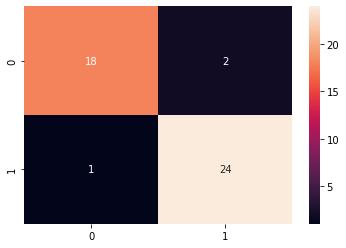

In [ ]:
# def plot confusion matrix
cm = confusion_matrix(bikesHorses.testLabels, svcModel.predict(testFeatures))
sns.heatmap(cm, annot=True)

### Logistic Regression

In [ ]:
def LRModel(features,labels):
    model = LogisticRegression(C=0.01,solver='lbfgs')
    model.fit(features,labels)
    return model

In [ ]:
lrModel = LRModel(trainFeatures,bikesHorses.trainLabels)

In [ ]:
accuracy = lrModel.score(testFeatures,bikesHorses.testLabels)

In [ ]:
print("Accuracy of model is {}".format(accuracy))

Accuracy of model is 0.9777777777777777


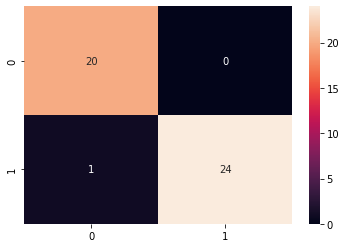

In [ ]:
cm = confusion_matrix(bikesHorses.testLabels, lrModel.predict(testFeatures))
sns.heatmap(cm, annot=True)

### KNN Model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def KNNModel(features,labels):
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(features,labels)
    return model

In [ ]:
knnModel = KNNModel(trainFeatures,bikesHorses.trainLabels)

In [ ]:
accuracy = knnModel.score(testFeatures,bikesHorses.testLabels)

In [ ]:
print("Accuracy of model is {}".format(accuracy))

Accuracy of model is 0.9111111111111111


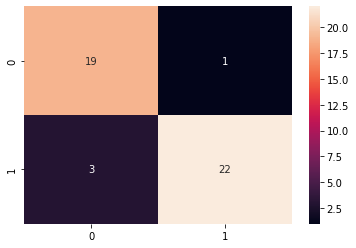

In [ ]:
cm = confusion_matrix(bikesHorses.testLabels, knnModel.predict(testFeatures))
sns.heatmap(cm, annot=True)